<a href="https://colab.research.google.com/github/kknd4eva/gpt_the_gathering/blob/main/gpt_the_gathering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tiktoken
!pip install openai


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
!unzip "/content/all_mtg_cards.zip" -d "/content/"

Archive:  /content/all_mtg_cards.zip
  inflating: /content/all_mtg_cards.csv  


In [7]:
import pandas as pd
import tiktoken

# There was a lot of rubbish characters and nonsense in the original dataset, so we ignore errors to build a reasonable list.
with open('/content/all_mtg_cards.csv',encoding='ISO-8859-1',errors='replace') as file:
  df = pd.read_csv(file, error_bad_lines=False, engine='python')

df.describe()

<ipython-input-7-03601f1d218a>:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(file, error_bad_lines=False, engine='python')


,multiverse_id,names,cmc,border,timeshifted,hand,life,reserved,release_date,starter,source
count,51694.000000,0.0,76436.000000,0.0,0.0,119.000000,119.000000,0.0,0.0,0.0,0.0
mean,313749.953283,NaN,29.149164,NaN,NaN,0.084034,1.084034,NaN,NaN,NaN,NaN
std,201678.312561,NaN,5115.191741,NaN,NaN,1.211385,5.683130,NaN,NaN,NaN,NaN
min,1.000000,NaN,0.000000,NaN,NaN,-4.000000,-8.000000,NaN,NaN,NaN,NaN
25%,108835.750000,NaN,2.000000,NaN,NaN,-1.000000,-3.000000,NaN,NaN,NaN,NaN
50%,394367.500000,NaN,3.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
75%,482881.750000,NaN,4.000000,NaN,NaN,1.000000,4.000000,NaN,NaN,NaN,NaN
max,597924.000000,NaN,1000000.000000,NaN,NaN,3.000000,30.000000,NaN,NaN,NaN,NaN


In [8]:
# getting the columns that are most useful for our purposes
new_df = df.loc[:, ['name', 'mana_cost','color_identity','type','rarity','text','flavor','power','toughness','image_url']]
new_df.describe()

,name,mana_cost,color_identity,type,rarity,text,flavor,power,toughness,image_url
count,76436,66587,68077,76436,76436,75429,38636,36183,36183,51694
unique,25937,757,31,2673,6,24842,20410,28,32,51460
top,Forest,{1}{W},['G'],Instant,Rare,({T}: Add {G}.),Lost to time is the artificer's art of trappin...,2,2,http://gatherer.wizards.com/Handlers/Image.ash...
freq,793,2142,11396,8381,26496,802,28,10543,8636,5


In [9]:
# reconstitute some of the columns to be more meaningful for our dataset 

# map color codes to colors
color_map = {'W': 'White', 'U': 'Blue', 'B': 'Black', 'R': 'Red', 'G': 'Green'}

# convert the unstructured mana costs into a list. 
def parse_cost(cost_str):
    cost = {'Any': 0}
    for mana_str in cost_str.split('{')[1:]:
        mana_type = mana_str.split('}')[0]
        try:
            mana_qty = int(mana_type)
            cost['Any'] += mana_qty
        except ValueError:
            if mana_type in cost:
                cost[mana_type] += 1
            else:
                cost[mana_type] = 1
    
    # Only include 'Any' if its value is non-zero
    if cost['Any'] == 0:
        del cost['Any']
    
    return {k: v for k, v in cost.items() if v > 0}

# color mapper
def map_colors(initials_list):
    return [color_map.get(initial) for initial in initials_list if initial in color_map]


new_df['mana_cost'] = new_df['mana_cost'].astype(str).apply(parse_cost)
new_df['color_identity'] = new_df['color_identity'].astype(str).apply(map_colors)

new_df = new_df.rename(columns={'text': 'abilities'})
new_df = new_df.rename(columns={'flavor': 'description'})


new_df.describe()


,name,mana_cost,color_identity,type,rarity,abilities,description,power,toughness,image_url
count,76436,76436,76436,76436,76436,75429,38636,36183,36183,51694
unique,25937,756,32,2673,6,24842,20410,28,32,51460
top,Forest,{},[Green],Instant,Rare,({T}: Add {G}.),Lost to time is the artificer's art of trappin...,2,2,http://gatherer.wizards.com/Handlers/Image.ash...
freq,793,10148,11396,8381,26496,802,28,10543,8636,5


In [10]:
# Define a lambda function to concatenate the text and column name in each row
concatenate = lambda row: " ".join([f"{col}: {val}" for col, val in zip(row.index, row)])

# Apply the lambda function to each row in the DataFrame
new_df['text'] = new_df.apply(concatenate, axis=1)
new_df.describe()

,name,mana_cost,color_identity,type,rarity,abilities,description,power,toughness,image_url,text
count,76436,76436,76436,76436,76436,75429,38636,36183,36183,51694,76436
unique,25937,756,32,2673,6,24842,20410,28,32,51460,66285
top,Forest,{},[Green],Instant,Rare,({T}: Add {G}.),Lost to time is the artificer's art of trappin...,2,2,http://gatherer.wizards.com/Handlers/Image.ash...,name: Forest mana_cost: {} color_identity: ['G...
freq,793,10148,11396,8381,26496,802,28,10543,8636,5,283


In [14]:
# You can run this cell to 'chop out' a smaller dataset to work with

# Specify the number of rows for the new dataframe
n_rows = 15000

# Sample n_rows randomly from the source dataframe
new_df = new_df.sample(n=n_rows)

1642286


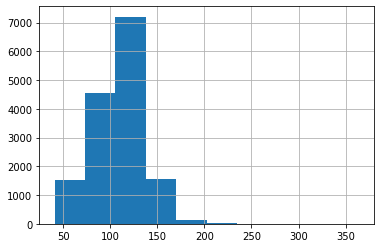

In [15]:
# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")


# Tokenize the text and save the number of tokens to a new column
new_df['n_tokens'] = new_df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
new_df.n_tokens.hist()
new_df.head()
print(sum(new_df['n_tokens']))

In [16]:
import openai
import os
import time
from tenacity import retry, wait_exponential
import concurrent.futures

openai.api_key = ""

# Define the retry configuration
retry_config = {
    'wait': wait_exponential(multiplier=1, max=60),
    'retry_error_cls': (openai.error.RateLimitError,)
}


# Define the function with the retry decorator
@retry(**retry_config)
def create_embedding(text):
    return openai.Embedding.create(input=text, engine='text-embedding-ada-002')['data'][0]['embedding']


# Apply the function to each text in the dataframe using parallel processing
with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    results = list(executor.map(create_embedding, new_df.text))

# Add the embeddings to the dataframe
new_df['embeddings'] = results


# Write the dataframe to CSV
new_df.to_csv('/content/embeddings.csv', index=False)

# Display the first few rows of the dataframe
print(new_df.head())


                        name           mana_cost color_identity  \
8593    Diversionary Tactics  {'Any': 3, 'W': 1}        [White]   
65480  Nahiri's Machinations  {'Any': 1, 'W': 1}   [Red, White]   
5487              Storm Crow  {'Any': 1, 'U': 1}         [Blue]   
52199           Spike Weaver  {'Any': 2, 'G': 2}        [Green]   
31843  Reassembling Skeleton  {'Any': 1, 'B': 1}        [Black]   

                             type    rarity  \
8593                  Enchantment  Uncommon   
65480                 Enchantment  Uncommon   
5487               Creature  Bird    Common   
52199             Creature  Spike      Rare   
31843  Creature  Skeleton Warrior  Uncommon   

                                               abilities  \
8593   Tap two untapped creatures you control: Tap ta...   
65480  At the beginning of combat on your turn, targe...   
5487   Flying (This creature can't be blocked except ...   
52199  Spike Weaver enters the battlefield with three...   
31843  {1}{B}:

In [17]:
# lets convert the embeddings column into a numpy array so we can use it further down (because we saved a CSV, our embeddings would just be strings)
import numpy as np
from openai.embeddings_utils import distances_from_embeddings

df=pd.read_csv('/content/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)


In [18]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [19]:
def answer_question(
    df,
    model="text-davinci-003",
    question="show me a random magic the gathering card?",
    max_len=1000,
    size="ada",
    debug=False,
    max_tokens=200,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"Hmm. Looks like I'm all tapped out of mana and can't answer that. Sorry!.\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0.4,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [28]:
answer_question(df, question="What card has the most positive description text, and what is that description text?")


'Heartwarming Redemption has the most positive description text: "Kytheon had known war every day of his life. Now he finally knew peace."'